# NLP Classification Using NLP

Prepared by Chris Gian for Hack Oregon's Week 
Sources:
- Based mostly on: [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class. 
- Adapted for use with sklearn way of text processing: [Working With Text Data](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
- Hobson Lane's book: [NLP in Action](https://www.manning.com/books/natural-language-processing-in-action)






## Setting up 


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Modules used for transforming "rotten tomatoes" reviews into a structured format.
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Read Data
critics = pd.read_csv('resources/critics.csv')

## Explore dataset

In [2]:
print("Number of rows: %i" % critics.shape[0])
print("Number of columns: %i" % critics.shape[1])

Number of rows: 27631
Number of columns: 8


In [3]:
critics.shape

(27631, 8)

In [4]:
critics.dropna().shape

(14792, 8)

In [5]:
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
0,Owen Gleiberman,fresh,114709,Entertainment Weekly,NaN,2011-09-07,9559,Toy story
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story



- How many total reviews are in this data set?
- How many unique critics?
- How many movies were reviewed and rated "fresh", "rotten", or "none"?

In [6]:
n_reviews = len(critics)
n_critics = critics.critic.unique().size
n_movies = critics.rtid.unique().size

print("Total reviews: %i" % n_reviews)
print("Unique critics: %i" % n_critics)
print("Number of movies :  %i" % n_movies)

Total reviews: 27631
Unique critics: 690
Number of movies :  2779


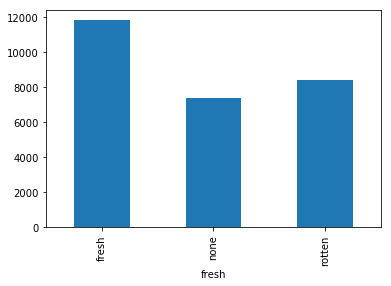

In [7]:
_ = critics.groupby("fresh").size().plot('bar')

## Prepare Data

In [8]:
df = critics.copy()
df = df.dropna()
df['fresh'] = df['fresh'] == 'fresh'
df.head(3)

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,True,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,True,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,True,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story


In [9]:
critics_stats = pd.pivot_table(df,
               index = ['critic'],
               values = ['fresh'],
               aggfunc=[np.mean,len],
               fill_value=0).sort_values(('len','fresh'), ascending = False)
critics_stats.head().append(critics_stats.tail())

,mean,len
,fresh,fresh
critic,,
Roger Ebert,0.673145,1132
James Berardinelli,0.603234,804
Janet Maslin,0.708738,515
Variety Staff,0.725581,430
Jonathan Rosenbaum,0.599515,412
Jessica Reaves,1.000000,1
Nick Schager,0.000000,1
Nicole Arthur,0.000000,1


In [10]:
critics_stats.shape

(622, 2)

## Concepts

### NLP Concepts
- **Corpus:** All documents being analyzed. (plural: corpora)
- **document:** A single element of the corpus
- **Lexicon (or vocabulary):** All the words across all documents.
- **Tokenization**: in each document, seperate each word into a element of a vector. Essential step for building TFM..
- **Bag of words:** When vectorized, we no longer retain order.
- **Term frequency Matrix**: A matrix of documents and words that belong. Each document occupies certain cells that belong to a word. Multiples of the same word show up as frequencies. Because this metric biases longer sentences, normalize with length of vector.
- **Inverse Document Frequency Matrix**: Another frequency matrix that shows how frequently a word appears in other documents. 
- **Term Frequency - Inverse Document Frequency**: Combination of TF*IDF has properties of both such that:
    - Words that show up frequently in a sentence are given higher weight
    - Words that show up TOO frequently across all documents are given lower weight


**corpus**

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

**Lexicon** 

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

**document**

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

** Tokenization **

`[A, Fox, one, day, spied, a, beautiful, bunch, of, ripe, grapes, hanging, from, a, vine, trained, along, the, branches, of, a, tree]`

**Count Vector: Relates the above document to the lexicon**

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,0,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 
    15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 
    30: tree, 31: vine, 
}
``



In our **rotten tomatoes data set**:
- Together, all data in "quote" is considered our corpus
- Each individual quote is a document
- The lexicon: the unique words across all documents in the corpus

## Prepare Data

In [11]:
X = df.quote
y = df.fresh

#### Create "Term-Frequency" Matrix
- Measures how often a word shows up as a proportion of all words in a document.
    - TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).
    - Denominator term normalizes so does not bias to longer sentences

In [12]:
vectorizer = CountVectorizer()
term_doc_matrix = vectorizer.fit_transform(X)
term_doc_matrix ## this is an important object for new data coming in

<14792x21799 sparse matrix of type '<class 'numpy.int64'>'
	with 259300 stored elements in Compressed Sparse Row format>

Explore one review. 
- Remove all the '0' cases to get just counts of words
- Change True to False to get Counts vs Weights

In [13]:
review_no = 0 

review_1 = pd.DataFrame(term_doc_matrix.toarray())
review_1 = review_1.iloc[[0]]
review_1.columns = vectorizer.get_feature_names()

review_1_cts = (
    review_1.T[review_1.T[0]!= 0 ]
    ).to_dict()

review_1_norm = (
    review_1.T[review_1.T[0]!= 0 ]/(
    len(df.iloc[review_no][4].split()))
    ).to_dict()

print("Review:%i, Critic: %s" % (review_no+1,df.iloc[review_no][0]))
print("")
print(X[review_no+1])
print("")
print("Frequency")
print("")
print(str(review_1_cts))
print("")
print("Frequency / Total words")
print("")
print(str(review_1_norm))


Review:1, Critic: Derek Adams

So ingenious in concept, design and execution that you could watch it on a postage stamp-sized screen and still be engulfed by its charm.

Frequency

{0: {'and': 2, 'be': 1, 'by': 1, 'charm': 1, 'concept': 1, 'could': 1, 'design': 1, 'engulfed': 1, 'execution': 1, 'in': 1, 'ingenious': 1, 'it': 1, 'its': 1, 'on': 1, 'postage': 1, 'screen': 1, 'sized': 1, 'so': 1, 'stamp': 1, 'still': 1, 'that': 1, 'watch': 1, 'you': 1}}

Frequency / Total words

{0: {'and': 0.083333333333333329, 'be': 0.041666666666666664, 'by': 0.041666666666666664, 'charm': 0.041666666666666664, 'concept': 0.041666666666666664, 'could': 0.041666666666666664, 'design': 0.041666666666666664, 'engulfed': 0.041666666666666664, 'execution': 0.041666666666666664, 'in': 0.041666666666666664, 'ingenious': 0.041666666666666664, 'it': 0.041666666666666664, 'its': 0.041666666666666664, 'on': 0.041666666666666664, 'postage': 0.041666666666666664, 'screen': 0.041666666666666664, 'sized': 0.041666666

- Notice now that none of the words are in order. This is our **"bag of words"**. We lose meaning, imagine "cat in the hat" vs "hat in the cat" = [cat,hat, in, the]

In [14]:
term_doc_matrix_df = term_doc_matrix.todense()
term_doc_matrix_df = pd.DataFrame(term_doc_matrix_df, columns=vectorizer.get_feature_names())

**Step 2: Inverse document Frequency**

Measures how important a word is. In TF, "And" is of equal value to the word "Inventive". But in reality, "And" is a frequent term across all reviews.

Other words of little importance may be: "is", "of", and "that". 

Thus our goal is to:
- Give little weight to words of little importance (show up very frequently)
- Give more weight to words that have high importance (Shows up rarely)
- Apply this to our term frequency 
Equation is:

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

In [15]:
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(term_doc_matrix) # notice how this can be "fit", "fit_transform", vs "transform"
tfidf_df = pd.DataFrame(tfidf.toarray(), columns= vectorizer.get_feature_names())
tfidf_df.head()

,000,0014,007,044,07,10,100,101,102,104,...,zooming,zooms,zorro,zorros,zowie,zucker,zweibel,zwick,zzzzzs,zzzzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### what if we wanted a vector representation of a new sentence?

"The quick brown fox jumps over the lazy dog."

In [16]:
new_sentence = ["The quick brown fox jumps over the lazy dog."]
tfm_new = vectorizer.transform(new_sentence)
tfidf_new = transformer.transform(tfm_new)

new_sentence = pd.DataFrame({"A. tfm":tfm_new.toarray()[0],"B. tfidf":tfidf_new.toarray()[0]}, index = vectorizer.get_feature_names())
new_sentence[new_sentence.iloc[:,1] != 0]

,A. tfm,B. tfidf
brown,1,0.409039
dog,1,0.341067
fox,1,0.400710
jumps,1,0.413791
lazy,1,0.409039
over,1,0.252316
quick,1,0.362456
the,2,0.149059


### Build a "Make X" function
that gives you:
- New X Frame
- Vectorizer to get TFM
- Transformer that gives you TFIDF

In [17]:
def make_X(data):
    vectorizer = CountVectorizer()
    term_doc_matrix = vectorizer.fit_transform(data)
    term_doc_matrix = term_doc_matrix.todense()
    term_doc_matrix = pd.DataFrame(term_doc_matrix)
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(term_doc_matrix)
    tfidf = pd.DataFrame(tfidf.toarray())
    return tfidf, vectorizer, transformer

### Training a Classifier
At this point you might have employed the following during feature engineering:
1. Dealt with contractions and abbreviations
2. normalized your vocabulary via
    - Case Norming
    - Stemming
    - Lemmatization
3. included a stop words list
    - words to exclude such as "it" or "the" 
4. Parts of Speech Tagging
5. Created "N-Grams" where your token looks like 
    - ["Ice Cream", "New York City"] rather than
    - [New, york, city, ice, cream]
6. Dimensionality reduction
7. included meta data such as time and critic

In [18]:
df.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,True,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,True,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,True,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,True,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,True,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [19]:
X2,vectorizer_2, transformer_2 = make_X(X)

In [20]:
X2.shape, y.shape

((14792, 21799), (14792,))

Train Test Split
- Set random seed to 100 for reproducibility
- Split data to 85% train, 15% test.
- Other methods include k-folds crossvalidation

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X2,y, test_size=0.15, random_state=100)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12573, 21799), (12573,), (2219, 21799), (2219,))

Bring in Naive Bayes Classifier

In [27]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=1)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

Classifier Performance:

In [28]:
print("Accuracy on Training Data: %f" % clf.score(X_train,y_train))
print("Accuracy on Test Data: %f" % clf.score(X_test,y_test))

Accuracy on Training Data: 0.818500
Accuracy on Test Data: 0.715638


In [29]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_pred = y_pred, y_true = y_test))

             precision    recall  f1-score   support

      False       0.90      0.30      0.45       863
       True       0.69      0.98      0.81      1356

avg / total       0.77      0.72      0.67      2219



In [30]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_pred= y_pred, y_true=y_test)
cm / cm.sum()

array([[ 0.1180712 ,  0.27084272],
       [ 0.0135196 ,  0.59756647]])

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
    - This represents the fact that each document will have exactly one word. One for each word that exists in our entire lexicon. 
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [31]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(N=X_train.shape[1]) # create a matrix of N by N with "Identity" meaning diagonal is 1
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
         masterpiece 0.96
             delight 0.95
          remarkable 0.94
            touching 0.94
            hypnotic 0.91
           absorbing 0.91
         beautifully 0.91
        entertaining 0.91
            intimate 0.91
             rousing 0.91
Bad words	     P(fresh | word)
            sluggish 0.18
       disappointing 0.17
               bland 0.17
         forgettable 0.17
       unfortunately 0.16
           pointless 0.15
      disappointment 0.14
             unfunny 0.14
          uninspired 0.13
                lame 0.11
